In [18]:
import sympy as sym
import numpy as np
from sympy import lambdify
from scipy.optimize import fsolve
import scipy.stats as st
import matplotlib.pyplot as plt
import os
from pathlib import Path
from utils import project_root
%matplotlib notebook

In [19]:
i = sym.symbols('i', cls=sym.Idx)
x = sym.Indexed('x', i)
y = sym.Indexed('y', i)
loc = sym.symbols('loc', real=True)
scale = sym.symbols ("scale", real=True)
c = sym.symbols('c', real=True, positive=True)
d = sym.symbols('d', real=True, positive=True)
n = sym.symbols('n', real=True)
j = sym.symbols('j', real=True, positive=True)
k = sym.symbols('k', real=True, positive=True)
m0 = sym.symbols('m0', real=True)
s0 = sym.symbols('s0', real=True)
m1 = sym.symbols('m1', real=True)
s1 = sym.symbols('s1', real=True)

In [20]:
os.chdir(Path(project_root() / 'data'))
print(os.getcwd())
vel_resid = np.load('velocity_residuals.npy')

/home/glob/Documents/github/thesis/data


Distributions that I can try: t
- dweibull: clearly overfits the data with no reasonable explanation for the 2 peaks of the distribution
- fisk, mielke, burr3, burr12, genlogistic only apply for a region of values for x 
- nct: We prefer the t-distribution over the nct because we assume that given a large enough dataset, the mean of our residuals will approximate 0
- genhyperbolic: Presents an error in the upper tail when plotting the probability plot of the c.d.f., so we cannot safely adopt it
- burr: Has no closed loop form for estimating c_hat, which is what mostly interests us
- johnsonsu: Has closed loop only for mean
- norminvgauss: Since the derivatives of the loglikelihood function involve the Bessel function, direct maximization is not an easy task 
- logistic: no closed loop form for loc, scale

# Normal GLRT with μ, σ changing

In [21]:
log_likelihood_normal = sym.log(s0/s1) + (x-m0)**2/(2*s0**2) - (x-m1)**2/(2*s1**2)
log_likelihood_normal

log(s0/s1) - (-m1 + x[i])**2/(2*s1**2) + (-m0 + x[i])**2/(2*s0**2)

In [22]:
f = (x-m0)**2/(2*s0**2) - (x-m1)**2/(2*s1**2)
s = sym.log(s0/s1) + sym.Sum(f, (i,j,k))
s

log(s0/s1) + Sum(-(-m1 + x[i])**2/(2*s1**2) + (-m0 + x[i])**2/(2*s0**2), (i, j, k))

In [23]:
ds_dm = sym.simplify(sym.diff(s, m1))
ds_dm

Sum(-m1 + x[i], (i, j, k))/s1**2

In [24]:
ds_ds = sym.simplify(sym.diff(s, s1))
ds_ds

-1/s1 + Sum(m1**2 - 2*m1*x[i] + x[i]**2, (i, j, k))/s1**3

In [25]:
# solving the 2 equations above gives:
t1 = (k-j+1)*m1**2
t2 = sym.Sum(2*x*m1 + x**2, (i,j,k))
s_1 = sym.sqrt(t1 + t2)
s_1

sqrt(m1**2*(-j + k + 1) + Sum(2*m1*x[i] + x[i]**2, (i, j, k)))

In [26]:
m_1 = (1/(k-j+1))*sym.Sum(x, (i,j,k))
m_1

Sum(x[i], (i, j, k))/(-j + k + 1)

In [27]:
s

log(s0/s1) + Sum(-(-m1 + x[i])**2/(2*s1**2) + (-m0 + x[i])**2/(2*s0**2), (i, j, k))

In [30]:
s.subs({m1:m_1, s1:s_1.subs({m1:m_1})})

log(s0/sqrt(Sum(x[i]**2 + 2*x[i]*Sum(x[i], (i, j, k))/(-j + k + 1), (i, j, k)) + Sum(x[i], (i, j, k))**2/(-j + k + 1))) + Sum(-(x[i] - Sum(x[i], (i, j, k))/(-j + k + 1))**2/(2*(Sum(x[i]**2 + 2*x[i]*Sum(x[i], (i, j, k))/(-j + k + 1), (i, j, k)) + Sum(x[i], (i, j, k))**2/(-j + k + 1))) + (-m0 + x[i])**2/(2*s0**2), (i, j, k))

# Logistic distribution

In [ ]:
i,j = sym.symbols('i j', cls=sym.Idx)

## p.d.f.

In [12]:
logistic_pdf = sym.exp(-x)/(1+sym.exp(-x))**2
logistic_pdf = logistic_pdf.subs(x, (y-loc)/scale)
logistic_pdf

exp(-(-loc + y[i])/scale)/(1 + exp(-(-loc + y[i])/scale))**2

In [13]:
loglogistic_pdf = sym.log(logistic_pdf)
loglogistic_pdf

log(exp(-(-loc + y[i])/scale)/(1 + exp(-(-loc + y[i])/scale))**2)

In [15]:
f = sym.Sum( loglogistic_pdf, (i, 1, n) )
sym.simplify(f)

Sum(log(exp(loc/scale)/(exp(2*loc/scale)*exp(-y[i]/scale) + 2*exp(loc/scale) + exp(y[i]/scale))), (i, 1, n))

In [18]:
df_dloc = sym.simplify(sym.diff(f, loc))
sym.simplify(df_dloc)

Sum((-exp(loc/scale) + exp(y[i]/scale))/(exp(loc/scale) + exp(y[i]/scale)), (i, 1, n))/scale

In [19]:
df_dscale = sym.simplify(sym.diff(f, scale))
sym.simplify(df_dscale)

Sum((loc*exp(loc/scale) - loc*exp(y[i]/scale) - exp(loc/scale)*y[i] + exp(y[i]/scale)*y[i])/(exp(loc/scale) + exp(y[i]/scale)), (i, 1, n))/scale**2

In [22]:
loc_hat = sym.solve(df_dloc, loc)
loc_hat

[]

In [23]:
scale_hat = sym.solve(df_dscale, scale)
scale_hat

[]

# Burr III distribution

In [29]:
k = sym.symbols('k', real=True)

## Probability Density Function

In [133]:
burr_pdf = (c*d*x**(-c-1))/((1 + x**(-c))**(d+1))
burr_pdf

c*d*(1 + x[i]**(-c))**(-d - 1)*x[i]**(-c - 1)

In [134]:
# burr_pdf_ = burr_pdf.subs(x, (y-loc)/scale)
# burr_pdf_

In [135]:
log_burr_pdf = sym.log(burr_pdf)
log_burr_pdf

log(c*d*(1 + x[i]**(-c))**(-d - 1)*x[i]**(-c - 1))

In [136]:
# log_burr_pdf_ = log_burr_pdf.subs(x, (y-loc)/scale)
# log_burr_pdf_

## Cummulative Density Function

In [137]:
burr_cdf = (1+x**(-c))**(-k)
burr_cdf

(1 + x[i]**(-c))**(-k)

## log-likelihood - MLE

In [138]:
g = sym.Sum( log_burr_pdf, (i, 1, n) )
sym.simplify(g)

(log(c) + log(d))*Sum(1, (i, 1, n)) + Sum(log(1/((1 + x[i]**(-c))**d*(x[i]**c + 1)*x[i])), (i, 1, n))

In [139]:
f1 = sym.Sum( sym.log(x**(-c-1)), (i, 1, n) )
f2 = sym.Sum( sym.log( c*d*(1 + x**(-c))**(-d-1)), (i, 1, n) )

# we must find the parameters c, d under which this term becomes 0
f = f1 + f2
sym.simplify(f)

n*log(c) + n*log(d) + Sum(log((1 + x[i]**(-c))**(-d - 1)) + log(x[i]**(-c - 1)), (i, 1, n))

In [140]:
df_dc = sym.simplify(sym.diff(f, c))
sym.simplify(df_dc)

Sum(d*log(x[i])/(x[i]**c + 1) - log(x[i]) + log(x[i])/(x[i]**c + 1) + x[i]**c/(c*(x[i]**c + 1)) + 1/(c*(x[i]**c + 1)), (i, 1, n))

In [141]:
df_dd = sym.simplify(sym.diff(f, d))
sym.simplify(df_dd)

-Sum(log(1 + x[i]**(-c)), (i, 1, n)) + n/d

In [142]:
# df_dloc = sym.simplify(sym.diff(g, loc))
# sym.simplify(df_dloc)

In [143]:
# df_dscale = sym.simplify(sym.diff(g, scale))
# sym.simplify(df_dscale)

## Calculate c_hat, d_hat

### Calculate d_hat (d that minimized the partial derivative of the likelihood function)

In [144]:
d_hat = sym.solve(df_dd, d)
sym.simplify(d_hat[0])

n/Sum(log(1 + x[i]**(-c)), (i, 1, n))

In [145]:
def find_d(x, c):
    num = len(x)
    temp = x**(-c)
    denom = sum(np.log(1+temp))
    
    return num/denom

### Calculate c_hat (c that minimized the partial derivative of the likelihood function)

In [146]:
df_dc = df_dc.subs(d, d_hat[0])
df_dc

Sum(n*log(x[i])/((x[i]**c + 1)*Sum(log(1 + x[i]**(-c)), (i, 1, n))) - log(x[i]) + log(x[i])/(x[i]**c + 1) + x[i]**c/(c*(x[i]**c + 1)) + 1/(c*(x[i]**c + 1)), (i, 1, n))

In [147]:
c_hat = sym.solve(df_dc, c)
c_hat

[]

### Calculate the second derivative w.r.t. c

In [150]:
der1 = sym.simplify(sym.diff(f, c))
der2 = sym.simplify(sym.diff(der1, c))
der2

Sum(-d*log(x[i])**2*x[i]**c/(x[i]**(2*c) + 2*x[i]**c + 1) - log(x[i])**2*x[i]**c/(x[i]**(2*c) + 2*x[i]**c + 1) - log(x[i])*x[i]**(2*c)/(c*(x[i]**(2*c) + 2*x[i]**c + 1)) - log(x[i])*x[i]**c/(c*(x[i]**(2*c) + 2*x[i]**c + 1)) + log(x[i])*x[i]**c/(c*(x[i]**c + 1)) - x[i]**c/(c**2*(x[i]**c + 1)) - 1/(c**2*(x[i]**c + 1)), (i, 1, n))

### Calculate loc_hat

In [ ]:
loc_hat = sym.solve(df_dloc, loc)
loc_hat

### Calculate scale_hat

In [ ]:
scale_hat = sym.solve(df_dscale, scale)
scale_hat

### Calculate c_hat numerically (find c that makes the term go to 0)

Note: 
- x is the velocity residuals
- n is the number of the velocity residuals

In [112]:
# the parameters of the burr distribution that fit our dataset
c_, d_, loc_, scale_ = 28.51108566150959, 0.9276442055923431, -1.53901917509511, 1.5508359728684877

In [113]:
vel_resids = np.array([(x_-loc_)/scale_ for x_ in vel_resid])

In [114]:
def min_f(x, c):
    n = len(x)

    t1 = sum(np.log(1+x**(-c)))
    t2 = x**c+1 
    
    term1 = sum((n*np.log(x))/(t2*t1))
    
    term2 = sum(np.log(x))
    
    term3 = sum(np.log(x)/t2)
    
    term4 = sum(x**c/(c*t2))
    
    term5 = sum(1/(c*t2))
    
    return term1 - term2 + term3 + term4 + term5

In [115]:
c_range = np.linspace(28.414, 28.416, 100)
f_values = []
for c_ in c_range:
    f = min_f(vel_resids, c_)
    
    f_values.append(f)

<IPython.core.display.Javascript object>


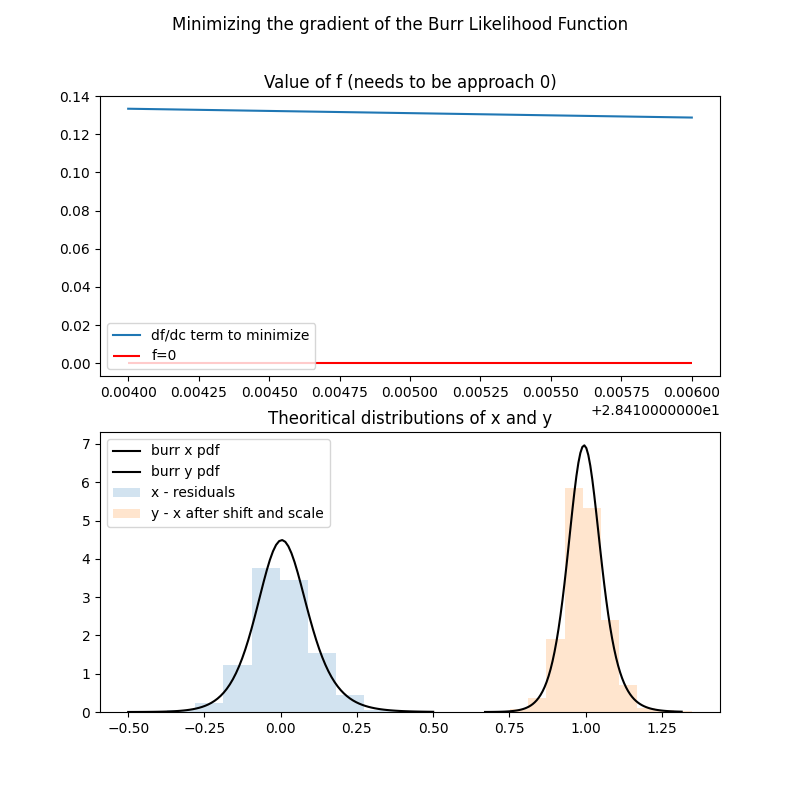

In [116]:
fig, axs = plt.subplots(2, figsize=(8,8))

axs[0].plot(c_range, f_values, label="df/dc term to minimize")
axs[0].hlines(0, min(c_range), max(c_range), 'r', label="f=0")

x_ = np.linspace(-0.5, 0.5, 100)
y_ = (x_-loc_)/scale_
rvx = st.burr(c_, d_, loc_, scale_)
rvy = st.burr(c_, d_)
axs[1].plot(x_, rvx.pdf(x_), 'k-', label='burr x pdf')
axs[1].plot(y_, rvy.pdf(y_), 'k-', label='burr y pdf')
x_range = st.burr.rvs(c_, d_, loc_, scale_, size=1000, random_state=0)
y_range = [(x-loc_)/scale_ for x in x_range]
axs[1].hist(x_range, density=True, histtype='stepfilled', alpha=0.2, label="x - residuals")
axs[1].hist(y_range, density=True, histtype='stepfilled', alpha=0.2, label="y - x after shift and scale")

fig.suptitle("Minimizing the gradient of the Burr Likelihood Function")
axs[0].legend()
axs[1].legend()
axs[0].set_title("Value of f (needs to be approach 0)")
axs[1].set_title("Theoritical distributions of x and y")
plt.show()

## Extract the values of c_hat and d_hat

In [117]:
c_hat = 28.415

In [118]:
d_hat = find_d(vel_resids, c_hat)

In [119]:
print(f"c_hat = {c_hat} \nd_hat = {d_hat}")

c_hat = 28.415 
d_hat = 0.9289893738250402


## Calculate log-likelihod under MLE parameters c_hat & d_hat

In [120]:
log_burr_pdf

log(c*d*(1 + x[i]**(-c))**(-d - 1)*x[i]**(-c - 1))

In [121]:
burr_pdf

c*d*(1 + x[i]**(-c))**(-d - 1)*x[i]**(-c - 1)

In [122]:
log_burr_pdf.subs({c:c_hat, d:d_hat})

log(26.3972330572385/((x[i]**(-28.415) + 1)**1.92898937382504*x[i]**29.415))

In [123]:
f0 = burr_pdf.subs({c:c_hat, d:d_hat})
f0

26.3972330572385/((x[i]**(-28.415) + 1)**1.92898937382504*x[i]**29.415)

## Maybe Paper - Calculate c_hat for Burr numerically
using the equations from https://arxiv.org/pdf/1901.09299.pdf

# END